# Improved LSTM model for toxic comment classification
This notebook is originally for the competition in kaggle https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge, and inspired from this kernel https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-069

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

Using TensorFlow backend.


### data loading and basic infomation
We include the GloVe word vectors in our input files. Train data is from wiki, 
test data was replaced from wiki data to reddit data (nba subreddit):

In [2]:
path = '../input/'
EMBEDDING_FILE=f'{path}glove.6B.100d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
# TEST_DATA_FILE=f'{path}test.csv'

train = pd.read_csv(TRAIN_DATA_FILE)
# test = pd.read_csv(TEST_DATA_FILE)
reddit_df=pd.read_csv(f'{path}reddit_nba_comment.csv')
reddit_df.columns=['id','comment_text']
test=reddit_df

In [3]:
train.head(7)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [4]:
train[train['severe_toxic']==1].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
181,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,1,1,1,0,1,0
442,01208d2b76624130,Hi \n\nIm a fucking bitch.\n\n50.180.208.181,1,1,1,0,1,0
579,018663f910e0bfe6,What a motherfucking piece of crap those fuckh...,1,1,1,0,1,0


In [5]:
print('train dataset shape: ',train.shape)

train dataset shape:  (159571, 8)


### Text cleaning
remove punctuation, remove stop words, lowercase, stem words

In [6]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
train['comment_text'] = train['comment_text'].apply(remove_punctuation)
test['comment_text'] = test['comment_text'].apply(remove_punctuation)

In [7]:
sw=stopwords.words('english')
def removesw(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)
train['comment_text'] = train['comment_text'].apply(removesw)
test['comment_text'] = test['comment_text'].apply(removesw)

In [8]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
train['comment_text'] = train['comment_text'].apply(stemming)
test['comment_text'] = test['comment_text'].apply(stemming)

### Exploratory analysis
Include: 
1. most frequently used words in toxic subset
2. sentence length comparision for toxic, severe toxic, and non-toxic subset
3. number of occurance for different types

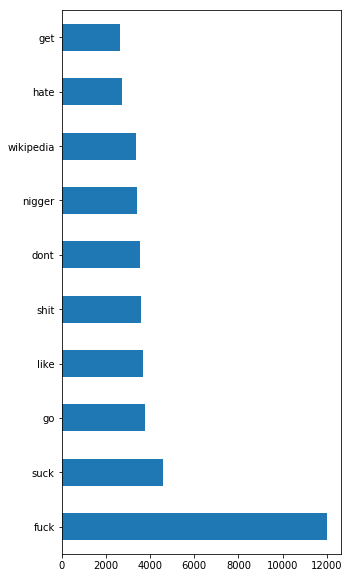

In [9]:
train['length'] = train['comment_text'].apply(len)
toxic_data = train[train['toxic'] == 1]
sevtoxic_data = train[train['severe_toxic'] == 1]
nontoxic=train[train.iloc[:,2:7].sum(axis=1)==0]

count=pd.Series(' '.join(toxic_data['comment_text']).split()).value_counts()
count=count.sort_values(ascending=False)
count_head=count.head(10)
count_head.plot(kind = 'barh', figsize=(5,10))

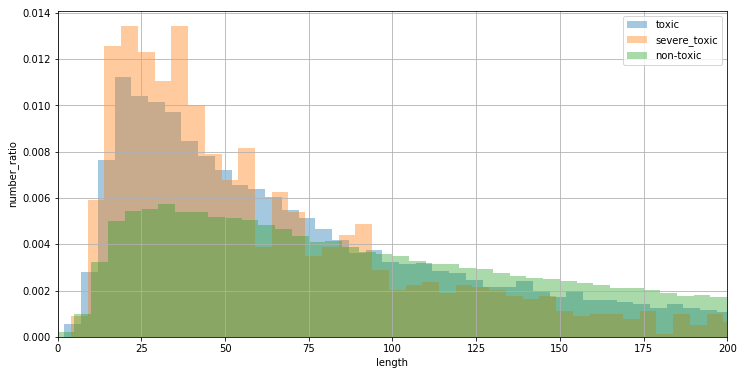

In [10]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 1000
plt.hist(toxic_data['length'], alpha = 0.4, bins=bins, label='toxic',density=True)
plt.hist(sevtoxic_data['length'], alpha = 0.4, bins=bins, label='severe_toxic',density=True)
plt.hist(nontoxic['length'], alpha = 0.4, bins=bins, label='non-toxic',density=True)
plt.xlabel('length')
plt.ylabel('number_ratio')
plt.legend(loc='upper right')
plt.xlim(0,200)
plt.grid()
plt.show()

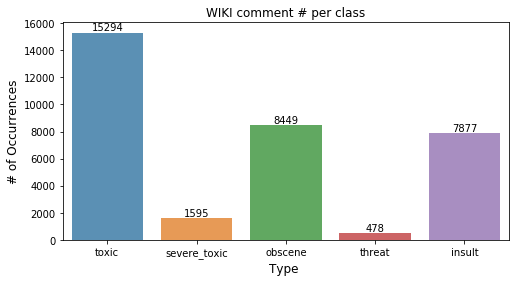

ratio of wiki toxic comment  0.21114738893658622


In [11]:
x=train.iloc[:,2:7].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("WIKI comment # per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
print('ratio of wiki toxic comment ',x.sum()/len(train))

### preparing data and model building

Set some basic config parameters:

In [12]:
embed_size = 100 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [13]:
EMBEDDING_FILE=f'{path}glove.6B.100d.txt'

Replace missing values

In [14]:
list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with padding as needed).

In [15]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [16]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

/home/zhixing/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [17]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

In [26]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])

x = Dense(100, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### model fitting and predicting

In [27]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1);

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1141s 8ms/step - loss: 0.0573 - acc: 0.9800 - val_loss: 0.0479 - val_acc: 0.9821
Epoch 2/2
143613/143613 [==============================] - 612s 4ms/step - loss: 0.0434 - acc: 0.9834 - val_loss: 0.0464 - val_acc: 0.9824


Save trained model

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [29]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

get predicted value, for kaggle competition need read sample_submission file

In [30]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)
#sample_submission = pd.read_csv(f'{path}{comp}sample_submission.csv')
#sample_submission[list_classes] = y_test
# sample_submission.to_csv('submission.csv', index=False)

165714/165714 [==============================] - 122s 737us/step


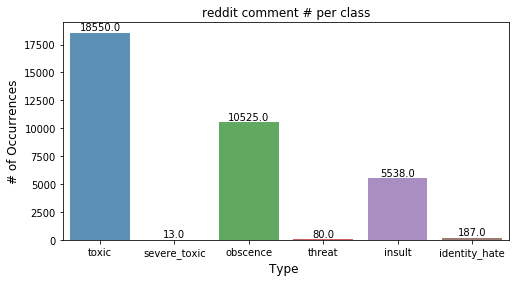

toxic ratio 0.21056156993374125


In [31]:
y_round=pd.DataFrame(y_test).round()
y_round.columns=['toxic','severe_toxic','obscence','threat','insult','identity_hate']
x=y_round.iloc[:,0:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("reddit comment # per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
print('toxic ratio',x.sum()/len(y_test))

In [32]:
reddit_df[y_round['toxic']==1].head(5)

,id,comment_text
33,33,probabl alreadi shark poop
39,39,ever see turtl nemo crush name nigga chill
57,57,get caught plastic bag suffoc peopl throw tras...
58,58,feel terrifi thank fuck doesn't know could die
70,70,unfortun there small chanc make adventur next ...


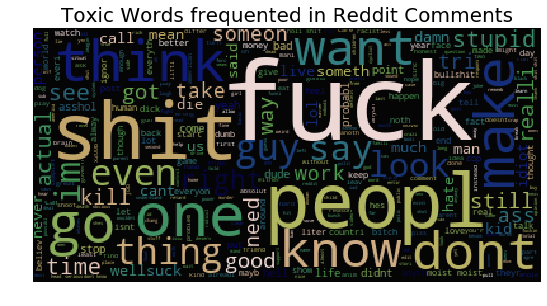

In [33]:
from wordcloud import WordCloud ,STOPWORDS
stopword=set(STOPWORDS)
subset=reddit_df[y_round.sum(axis=1)!=0]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Toxic Words frequented in Reddit Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)